## 전체 기본 환경 설정

In [100]:
%pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

Note: you may need to restart the kernel to use updated packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 54 not upgraded.


In [101]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
from scipy import stats

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

## 데이터 불러오기

In [110]:
train = pd.read_csv('/data/ephemeral/home/code/train.csv')
test = pd.read_csv('/data/ephemeral/home/code/test.csv')
subway = pd.read_csv('/data/ephemeral/home/code/subway_feature.csv')
bus = pd.read_csv('/data/ephemeral/home/code/bus_feature.csv')
GIS = pd.read_csv('/data/ephemeral/home/code/GIS_output.csv')

In [112]:
# Train data와 Test data shape
print('Train data shape : ', train.shape, 
      '\nTest data shape : ', test.shape, 
      '\nTrain_GIS data shape : ', GIS.shape,
      '\nBus data shape : ', bus.shape,
      '\nSubway data shape : ', subway.shape)

Train data shape :  (1118822, 52) 
Test data shape :  (9272, 51) 
Train_GIS data shape :  (695900, 30) 
Bus data shape :  (12584, 6) 
Subway data shape :  (768, 5)


In [113]:
# Train과 Test data를 살펴보겠습니다.
display(train.head(1))
display(test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.
display(GIS.head(1))
display(bus.head(1))
display(subway.head(1))


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,...,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


,원천도형ID,GIS건물통합식별번호,고유번호,법정동코드,법정동명,지번,특수지코드,특수지구분명,건축물용도코드,건축물용도명,...,위반건축물여부,참조체계연계키,데이터기준일자,원천시도시군구코드,건물명,건물동명,지상층_수,지하층_수,데이터생성변경일자,geometry
0,32,1991201839054527769900000000,1111017500107040000,1111017500,서울특별시 종로구 숭인동,704,1,일반,01000,단독주택,...,N,B00100000000T30Z9,2024-11-01,11110,NaN,NaN,3.0,0.0,2017-05-30,POLYGON ((201913.63771092566 553085.3228524396...


,노드 ID,정류소번호,정류소명,X좌표,Y좌표,정류소 타입
0,100000001,1001,종로2가사거리,126.987752,37.569808,중앙차로


,역사_ID,역사명,호선,위도,경도
0,9996,미사,5호선,37.560927,127.193877


## Data 전처리

### Train/Test 구분 및 합치기

In [105]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
train['is_test'] = 0
test['is_test'] = 1

In [106]:
dt_concat = pd.concat([train, test])     # 하나의 데이터로 만들어줍니다.

In [9]:
dt_concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

### dt_concat 전처리

[컬럼 변경]
1. 컬럼 이름 변경 
2. 지번 생성(본번 + - + 부번)
3. 계약년월 split : 계약년, 계약월
4. 시군구 split : 시, 군, 구

[값 변경]
1. 단지분류 컬럼 (도시형 생활주택(주상복합)/주상복합, 도시형 생활주택(아파트)/아파트)

- 세대타입 : 분양/기타/임대 -> 분양/임대

[드랍 피쳐 결정]
- '전화번호', '팩스번호', '전용면적>135', '해제사유발생일', 
- '관리방식', '시', '사용허가여부', '경비비관리형태', '청소비관리형태', '세대전기계약방식', '시행사', '관리비 업로드', '고용보험관리번호', '수정일자'

[결측치 처리]
1. 결측치 90% 이상 차지하는 변수 제거
2. 값은 있지만, 의미없는 value가 있는 경우(예: ' ') 결측치 처리: 등기신청일자, 거래유형, 중개사소재지 
2. 나머지 결측치는 선형보간(Linear interpolation)으로 대체

[변수 보간]
- 범주형 변수의 경우 최빈값(mode)으로 보간
- 연속형 변수의 경우 선형보간(Linear interpolation)으로 보간


#### 컬럼 이름 변경 또는 변수 분할

In [115]:
# 컬럼 이름 변경
dt_concat = dt_concat.rename(columns={'전용면적(㎡)':'전용면적',
                                'k-단지분류(아파트,주상복합등등)':'단지분류', 
                                'k-전화번호':'전화번호', 
                                'k-팩스번호':'팩스번호',
                                'k-세대타입(분양형태)':'세대타입',
                                'k-관리방식':'관리방식',
                                'k-복도유형':'복도유형', 
                                'k-난방방식':'난방방식',
                                'k-전체동수':'전체동수', 
                                'k-전체세대수':'전체세대수',
                                'k-건설사(시공사)':'건설사',
                                'k-시행사':'시행사',
                                'k-연면적':'연면적',
                                'k-주거전용면적':'주거전용면적',
                                'k-관리비부과면적':'관리비부과면적',
                                'k-전용면적별세대현황(60㎡이하)':'전용면적<60',
                                'k-전용면적별세대현황(60㎡~85㎡이하)':'전용면적60~85',
                                'k-85㎡~135㎡이하':'전용면적85~135',
                                'k-135㎡초과':'전용면적>135', 
                                'k-홈페이지':'홈페이지',
                                'k-등록일자':'등록일자', 
                                'k-수정일자':'수정일자'})

In [116]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
dt_concat['시'] = dt_concat['시군구'].map(lambda x : x.split()[0])
dt_concat['구'] = dt_concat['시군구'].map(lambda x : x.split()[1])
dt_concat['동'] = dt_concat['시군구'].map(lambda x : x.split()[2])
del dt_concat['시군구']

# 계약년월 split
dt_concat['계약년'] = dt_concat['계약년월'].astype('str').map(lambda x : x[:4])
dt_concat['계약월'] = dt_concat['계약년월'].astype('str').map(lambda x : x[4:])
del dt_concat['계약년월']

In [117]:
dt_concat.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', '해제사유발생일',
       '등기신청일자', '거래유형', '중개사소재지', '단지분류', '전화번호', '팩스번호', '단지소개기존clob',
       '세대타입', '관리방식', '복도유형', '난방방식', '전체동수', '전체세대수', '건설사', '시행사',
       'k-사용검사일-사용승인일', '연면적', '주거전용면적', '관리비부과면적', '전용면적<60', '전용면적60~85',
       '전용면적85~135', '전용면적>135', '홈페이지', '등록일자', '수정일자', '고용보험관리번호', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일',
       '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', '시',
       '구', '동', '계약년', '계약월'],
      dtype='object')

#### 컬럼 별 값 확인 후 수정 및 결측치 처리

In [118]:
display(dt_concat['전용면적<60'].value_counts())

0.0       54234
1150.0     3068
370.0      2893
4975.0     2816
750.0      2744
          ...  
543.0         5
438.0         2
614.0         2
9.0           1
1395.0        1
Name: 전용면적<60, Length: 349, dtype: int64

In [119]:
# 각 컬럼 별 값을 변경
dt_concat['등기신청일자'] = dt_concat['등기신청일자'].replace(' ', np.nan)
dt_concat['거래유형'] = dt_concat['거래유형'].replace('-', np.nan)
dt_concat['중개사소재지'] = dt_concat['중개사소재지'].replace('-', np.nan)
dt_concat['건축면적'] = dt_concat['건축면적'].replace(np.int64(0), np.nan)
dt_concat['주차대수'] = dt_concat['주차대수'].replace(np.int64(0), np.nan)
dt_concat['전용면적<60'] = dt_concat['전용면적<60'].replace(np.int64(0), np.nan)
dt_concat['전용면적60~85'] = dt_concat['전용면적60~85'].replace(np.int64(0), np.nan)
dt_concat['전용면적85~135'] = dt_concat['전용면적85~135'].replace(np.int64(0), np.nan)
dt_concat['전용면적>135'] = dt_concat['전용면적>135'].replace(np.int64(0), np.nan)
dt_concat.loc[dt_concat['층'] < 0, '층'] = 1
dt_concat['단지분류'] = dt_concat['단지분류'].replace('도시형 생활주택(주상복합)', '주상복합')
dt_concat['단지분류'] = dt_concat['단지분류'].replace('도시형 생활주택(아파트)', '아파트')

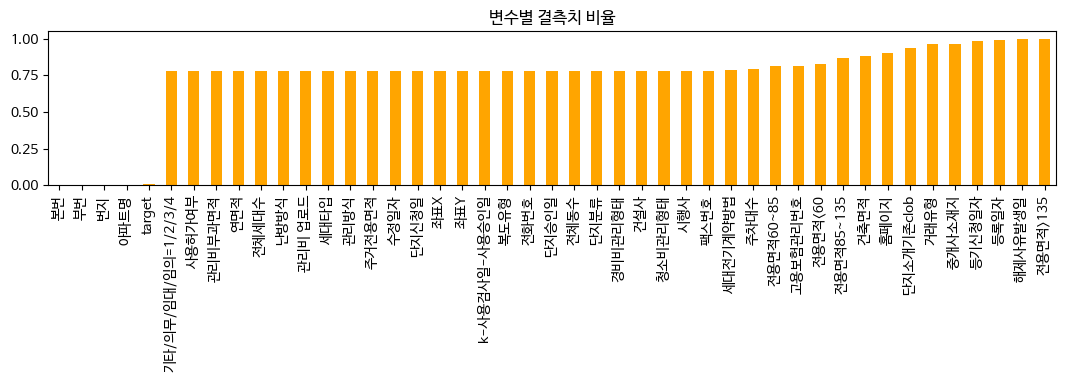

In [120]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = dt_concat.isnull().sum() / dt_concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

#### 피쳐 드랍

In [61]:
# display(dt_concat['거래유형'].value_counts())

중개거래    38123
직거래      3520
Name: 거래유형, dtype: int64

In [63]:
direct = dt_concat[(dt_concat['is_test']==0) & (dt_concat['거래유형']=='직거래')]['target']
broker = dt_concat[(dt_concat['is_test']==0) & (dt_concat['거래유형']=='중개거래')]['target']

t_stat, p_value = stats.ttest_ind(direct, broker)
print("\nt-statistic:", t_stat)
print("p-value:", p_value)


t-statistic: -28.3381116894659
p-value: 1.5942351178919688e-174


In [121]:
# Null값이 100만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print('* 결측치가 100만개 이하인 변수들 :', list(dt_concat.columns[dt_concat.isnull().sum() <= 1000000]))     # 남겨질 변수들은 아래와 같습니다.
print('* 결측치가 100만개 이상인 변수들 :', list(dt_concat.columns[dt_concat.isnull().sum() >= 1000000]))

* 결측치가 100만개 이하인 변수들 : ['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', '단지분류', '전화번호', '팩스번호', '세대타입', '관리방식', '복도유형', '난방방식', '전체동수', '전체세대수', '건설사', '시행사', 'k-사용검사일-사용승인일', '연면적', '주거전용면적', '관리비부과면적', '전용면적<60', '전용면적60~85', '전용면적85~135', '수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', '시', '구', '동', '계약년', '계약월']
* 결측치가 100만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지소개기존clob', '전용면적>135', '홈페이지', '등록일자']


In [122]:
# 위에서 결측치가 100만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(dt_concat.columns[dt_concat.isnull().sum() <= 1000000])
dt_concat_select = dt_concat[selected]

In [123]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
dt_concat_select['본번'] = dt_concat_select['본번'].astype('str')
dt_concat_select['부번'] = dt_concat_select['부번'].astype('str')

In [124]:
# 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in dt_concat_select.columns:
    if pd.api.types.is_numeric_dtype(dt_concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', '전체동수', '전체세대수', '연면적', '주거전용면적', '관리비부과면적', '전용면적<60', '전용면적60~85', '전용면적85~135', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_test']
범주형 변수: ['번지', '본번', '부번', '아파트명', '도로명', '단지분류', '전화번호', '팩스번호', '세대타입', '관리방식', '복도유형', '난방방식', '건설사', '시행사', 'k-사용검사일-사용승인일', '수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', '시', '구', '동', '계약년', '계약월']


In [125]:
print(len(continuous_columns), len(categorical_columns))

18 30


In [126]:
# 드랍할 범주형 피쳐 정의
except_catcol = ['전화번호', '팩스번호', 'k-사용검사일-사용승인일', '수정일자', '고용보험관리번호', '청소비관리형태','단지승인일']

dt_concat_select = dt_concat_select.drop(columns=except_catcol)

In [127]:
# 드랍할 연속형 피쳐 확인
except_contcol = []

dt_concat_select = dt_concat_select.drop(columns=except_contcol)

#### 파생변수 생성

In [145]:
# 구 티어 
goo = list(dt_concat_select['구'].unique())

tier1 = ['강남구', '서초구', '용산구', '송파구', '성동구']
tier2 = ['마포구', '광진구', '동작구', '영등포구', '중구', '종로구', '강동구', '양천구', '서대문구']
# tier3 = ['동대문구', '강서구', '광악구', '은평구']


tier3 = [x for x in goo if x not in tier1 + tier2]

assert len(goo) == len(tier1) + len(tier2) + len(tier3)       # 알맞게 분리되었는지 체크합니다.

In [146]:
# 강남의 여부를 체크합니다.
goo_tier = []
for x in dt_concat_select['구'].tolist() :
  if x in tier1 :
    goo_tier.append(1)  
  elif x in tier2 :
    goo_tier.append(2)
  else :
    goo_tier.append(3)

# 파생변수를 하나 만릅니다.
dt_concat_select['구 티어'] = goo_tier

In [180]:
# 동 티어
dong = list(dt_concat_select['동'].unique())

# Define tiers
t1 = ['반포동', '개포동', '압구정동', '대치동', '잠원동', '잠실동', '일원동', '수서동', '평동', '홍파동', '삼성동', '청담동', '도곡동', '교북동', '성수동1가', '한남동', '용강동']
t2 = ['아현동', '신계동', '신천동', '역삼동', '보광동', '용산동5가', '북아현동', '만리동2가','용문동', '자곡동', '신원동', '이촌동', '성수동2가', '상수동', '서빙고동', '옥수동', '금호동4가', '고덕동', '금호동2가', '세곡동', '장지동', '현석동', '내곡동']
t3 = ['상왕십리동', '우면동', '염리동', '흑석동', '서초동', '한강로3가', '논현동', '여의도동', '방배동', '대흥동', '광장동', '상일동', '공덕동', '한강로1가', '방이동', '영등포동7가', '토정동', '중림동', '금호동1가', '원효로4가', '행당동', '신공덕동', '하왕십리동', '원효로1가', '동작동', '송파동', '만리동1가', '이태원동', '목동']


# Convert back to list if needed
t4 = [x for x in dong if x not in t1 + t2 + t3]

# # Check if all 'dong' are categorized
assert len(dong) == len(t1) + len(t2) + len(t3) + len(t4), "Mismatch in tier categorization"

In [181]:
dong_tier = []
for x in dt_concat_select['동'].tolist() :
    if x in t1 :
        dong_tier.append(1)
    elif x in t2 :
        dong_tier.append(2)
    else :
        dong_tier.append(3)
dt_concat_select['동 티어'] = dong_tier

In [183]:
# 건축년도 tier
dt_concat_select['전체세대수'].describe(percentiles=[0.25, 0.5, 0.75, 1])


count    251969.000000
mean       1186.767436
std        1197.452046
min          59.000000
25%         405.000000
50%         768.000000
75%        1622.000000
100%       9510.000000
max        9510.000000
Name: 전체세대수, dtype: float64

In [154]:
bldg_age = list(dt_concat_select['건축년도'].unique())

new = list(range(1961, 1992))
mid = list(range(1993, 2000))
old = list(range(2001, 2005))
vold = list(range(2006, 2023))

In [155]:
bldg_tier = []
for x in dt_concat_select['건축년도'].tolist() :
    if x in new :
        bldg_tier.append(1)
    elif x in mid :
        bldg_tier.append(2)
    elif x in old :
        bldg_tier.append(3)
    else :
        bldg_tier.append(4)
dt_concat_select['건축년도 티어'] = bldg_tier

In [156]:
dt_concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', '단지분류',
       '세대타입', '관리방식', '복도유형', '난방방식', '전체동수', '전체세대수', '건설사', '시행사', '연면적',
       '주거전용면적', '관리비부과면적', '전용면적<60', '전용면적60~85', '전용면적85~135', '경비비관리형태',
       '세대전기계약방법', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', '시', '구', '동', '계약년', '계약월',
       '구 티어', '건축년도 티어'],
      dtype='object')

#### 상관관계 확인
- 전용면적, 관리비부과면적, 주거전용면적, 연면적, 주차대수와 높은 상관관계를 보임

- 건축년도와 전용면적은 반비례 관계를 보임

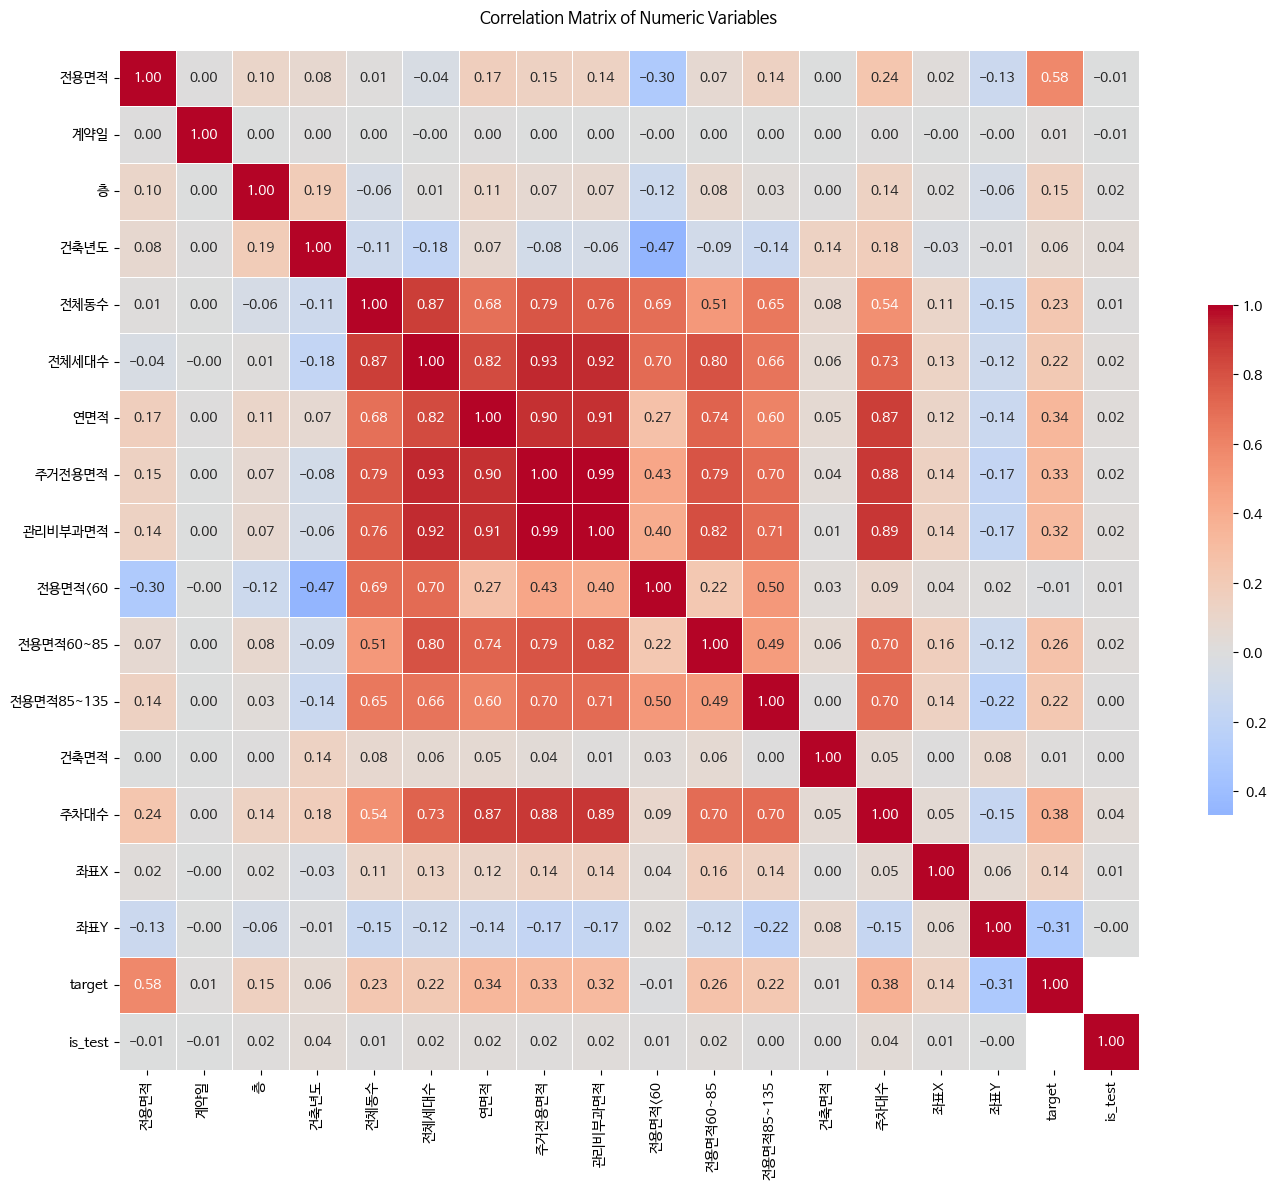

In [71]:
# 연속형 변수들의 상관관계 Heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(dt_concat_select[continuous_columns].corr(), 
            annot=True,              # 상관계수 표시
            cmap='coolwarm',         # 색
            center=0,                # 상관계수 표시 중심값 0
            fmt='.2f',              # 소수점 2자리 표시
            square=True,            # 정사각형 형태
            linewidths=0.5,         # 그리드 선 두께
            cbar_kws={"shrink": .5} # 색상 바 크기 조절
           )
plt.title('Correlation Matrix of Numeric Variables', pad=20)
plt.tight_layout()
plt.show()


### 변수 보간

In [84]:
# train/test 데이터 분리
train_dt2 = dt_concat_select.query('is_test==0')
test_dt2 = dt_concat_select.query('is_test==1')

#### train data 전처리

In [85]:
# 위에서 피쳐 드랍을 했으니 다시 범주형, 연속형 변수 분리
continuous_columns = []
categorical_columns = []

for column in train_dt2.columns:
    if pd.api.types.is_numeric_dtype(train_dt2[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', '전체동수', '전체세대수', '연면적', '주거전용면적', '관리비부과면적', '전용면적<60', '전용면적60~85', '전용면적85~135', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_test']
범주형 변수: ['번지', '본번', '부번', '아파트명', '도로명', '단지분류', '세대타입', '관리방식', '복도유형', '난방방식', '건설사', '시행사', '경비비관리형태', '세대전기계약방법', '기타/의무/임대/임의=1/2/3/4', '사용허가여부', '관리비 업로드', '단지신청일', '시', '구', '동', '계약년', '계약월']


#### 범주형 변수 Encoding

In [95]:
# 복도유형: 최신 아파트 중 많은 유형은 계단식(?) 타워형+복도식+기타
# 계약년, 월은 bin?
train_dt2['경비비관리형태'].value_counts()

위탁       206401
직영        33526
위탁+직영      6108
기타         1799
Name: 경비비관리형태, dtype: int64

In [87]:
train_dt2[categorical_columns].isnull().sum()

번지                        225
본번                          0
부번                          0
아파트명                     2126
도로명                         0
단지분류                   870691
세대타입                   869563
관리방식                   869563
복도유형                   869890
난방방식                   869563
건설사                    871058
시행사                    871254
경비비관리형태                870988
세대전기계약방법               878747
기타/의무/임대/임의=1/2/3/4    869563
사용허가여부                 869563
관리비 업로드                869563
단지신청일                  869625
시                           0
구                           0
동                           0
계약년                         0
계약월                         0
dtype: int64

In [96]:
# Encoding 방법에 따라 피쳐 분리 정의
ohe_col = []
le_col = ['단지분류', '세대타입', '복도유형', '난방방식', '경비비관리형태', '세대전기계약방식', '관리비업로드', '기타/의무/임대/임의=1/2/3/4']
freq_col = ['아파트명','건설사', '시행사']
te_col = []

In [ ]:
label_encoders = {}

# Implement Label Encoding
for col in tqdm( le_col ):
    LBE = LabelEncoder()

    # Label-Encoding을 fit
    LBE.fit( train_dt2[col].astype(str) )
    train_dt2[col] = LBE.transform(train_dt2[col].astype(str))
    label_encoders[col] = LBE           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(test_dt2[col]):
      if label not in LBE.classes_: # unseen label 데이터인 경우
        LBE.classes_ = np.append(LBE.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    test_dt2[col] = LBE.transform(test_dt2[col].astype(str))

In [ ]:
# Frequency Encoding
frequency_encoders = {}

for col in freq_col:
    FE = train_dt2[col].value_counts()
    frequency_encoders[col] = FE
    train_dt2[f'FE_{col}'] = train_dt2[col].map(FE)

display(train_dt2.head())

display(f"{col}의 인코딩 값: {train_dt2[train_dt2['아파트명'] == '**']['FE_아파트명'][0]}")


In [ ]:
# 범주형 변수에 대한 보간
dt_concat_select[categorical_columns] = dt_concat_select[categorical_columns].fillna('NULL')

#### 수치형 변수 보간

In [ ]:
# Encoding 방법에 따라 피쳐 분리 정의
log_col = ['']
minmax_col = ['']
std_col = ['']
robust_col = ['']
bin_col = ['']

In [73]:
dt_concat_select[continuous_columns].isnull().sum()

전용면적               0
계약일                0
층                  0
건축년도               0
전체동수          877207
전체세대수         876125
연면적           876125
주거전용면적        876170
관리비부과면적       876125
전용면적<60       930404
전용면적60~85     919512
전용면적85~135    976547
건축면적          994673
주차대수          894418
좌표X           876232
좌표Y           876232
target          9272
is_test            0
dtype: int64

In [ ]:
# 연속형 변수에 대한 보간 (선형 보간)
dt_concat_select[continuous_columns] = dt_concat_select[continuous_columns].interpolate(method='linear', axis=0)